In [118]:
from TIMIT.lightning_model_uncertainty_loss import LightningModel
import os
import pandas as pd
import numpy as np
import torch
import torchaudio
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from IPython import embed

In [3]:
model_checkpoint = 'checkpoints/epoch=12-step=6369-v3.ckpt'
model = LightningModel.load_from_checkpoint(model_checkpoint)
model.to('cuda')
model.eval()
print()

Using cache found in /root/.cache/torch/hub/s3prl_s3prl_master


Using cache found in /root/.cache/torch/hub/s3prl_cache/3a990c945fbe378df95598eec534e91ba22a5d9eab0b2f88777a7a696d1344e9
for https://dl.fbaipublicfiles.com/fairseq/wav2vec/wav2vec_small.pt
Model Details: #Params = 164364294	#Trainable Params = 161212422



In [40]:
model.model.transformer_encoder_M.layers[-5]

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [4]:
phnFiles = os.listdir('./TIMIT_Dataset/wav_data/phn')
testWavFiles = os.listdir('./TIMIT_Dataset/wav_data/TEST')
phnFiles.sort()
testWavFiles.sort()
print(len(phnFiles), len(testWavFiles))

6300 1680


In [5]:
phnFiles[:5]

['FADG0_SA1.PHN',
 'FADG0_SA2.PHN',
 'FADG0_SI1279.PHN',
 'FADG0_SI1909.PHN',
 'FADG0_SI649.PHN']

In [6]:
testWavFiles[:5]

['FADG0_SA1.WAV',
 'FADG0_SA2.WAV',
 'FADG0_SI1279.WAV',
 'FADG0_SI1909.WAV',
 'FADG0_SI649.WAV']

In [48]:
testPhnWavFiles = []

for i,testWavFile in enumerate(testWavFiles):
    if((testWavFile[:-4]+'.PHN') in phnFiles):
        testPhnWavFiles.append(['./TIMIT_Dataset/wav_data/TEST/'+testWavFile, './TIMIT_Dataset/wav_data/phn/'+testWavFile[:-4]+'.PHN'])
len(testPhnWavFiles)

1680

In [49]:
testPhnWavFiles[:5]

[['./TIMIT_Dataset/wav_data/TEST/FADG0_SA1.WAV',
  './TIMIT_Dataset/wav_data/phn/FADG0_SA1.PHN'],
 ['./TIMIT_Dataset/wav_data/TEST/FADG0_SA2.WAV',
  './TIMIT_Dataset/wav_data/phn/FADG0_SA2.PHN'],
 ['./TIMIT_Dataset/wav_data/TEST/FADG0_SI1279.WAV',
  './TIMIT_Dataset/wav_data/phn/FADG0_SI1279.PHN'],
 ['./TIMIT_Dataset/wav_data/TEST/FADG0_SI1909.WAV',
  './TIMIT_Dataset/wav_data/phn/FADG0_SI1909.PHN'],
 ['./TIMIT_Dataset/wav_data/TEST/FADG0_SI649.WAV',
  './TIMIT_Dataset/wav_data/phn/FADG0_SI649.PHN']]

# Phone map

In [95]:
# https://catalog.ldc.upenn.edu/docs/LDC93S1/PHONCODE.TXT
symbolList = [                                      
                  'b',          
                  'd',          
                  'g',          
                  'p',          
                  't',          
                  'k',         
                  'dx',         
                  'q',          

                  'jh',         
                  'ch',         

                  's',          
                  'sh',         
                  'z',          
                  'zh',         
                  'f',          
                  'th',         
                  'v',           
                  'dh',         

                  'm',          
                  'n',         
                  'ng',         
                  'em',         
                  'en',         
                  'eng',        
                  'nx',         
                             
                  'l',          
                  'r',          
                  'w',          
                  'y',          
                  'hh',         
                  'hv',         
                  'el',         
                  
                  'iy',        
                  'ih',          
                  'eh',         
                  'ey',         
                  'ae',         
                  'aa',         
                  'aw',         
                  'ay',         
                  'ah',         
                  'ao',         
                  'oy',         
                  'ow',         
                  'uh',         
                  'uw',         
                  'ux',         
                  'er',         
                  'ax',        
                  'ix',        
                  'axr',        
                  'ax-h',      

                  'pau',     
                  'epi',     
                  'h#',     
                  '1',       
                  '2' 

                   'bcl','dcl','gcl','pcl','tck','kcl','tcl']    

In [96]:
len(symbolList)

63

In [108]:
def getSymbolInfo(phnFile, maxProbSymbolIndices):
    with open(testPhnWavFiles[0][1]) as f:
        lines = f.readlines()
    for line in lines:
        lo, hi, symbol = line.split(" ")
        lo = int(lo)
        hi = int(hi)
        if(symbol[-1] == '\n'):
            symbol = symbol[:-1]
#         print(lo, hi, symbol)
        assert(symbol in symbolList)
        
        for maxProbSymbolIndex in maxProbSymbolIndices:
            lo_ = maxProbSymbolIndex*320
            hi_ = maxProbSymbolIndex*320+400
            if(lo<=lo_<=hi or lo<=hi_<=hi):
                symbolCountMap[symbol] += 1
#                 print(lo, hi, lo_, hi_, maxProbSymbolIndex)

# Making Plots

In [98]:
activation_M = {}
def get_activation_M(name):
    def hook(model, input, output):
        activation_M[name] = output
    return hook

activation_F = {}
def get_activation_F(name):
    def hook(model, input, output):
        activation_F[name] = output
    return hook

In [99]:
# model

In [100]:
model.model.transformer_encoder_M.layers[5].self_attn.register_forward_hook(get_activation_M('attn_M'))
model.model.transformer_encoder_F.layers[5].self_attn.register_forward_hook(get_activation_F('attn_F'))

In [111]:
symbolCountMap = {x: 0 for x in symbolList}

for i,testPhnWavFile in enumerate(testPhnWavFiles):
    wav, _ = torchaudio.load(testPhnWavFile[0])
    wav_len = [wav.shape[1]]
    wav = wav.to('cuda')
    y_hat_h, y_hat_a, y_hat_g = model(wav, wav_len)
    y_hat_h = y_hat_h.to('cpu')
    y_hat_a = y_hat_a.to('cpu')
    y_hat_g = y_hat_g.to('cpu')
    
    phnFile = testPhnWavFile[1]
    
    if(y_hat_g>0.5):
        activation_F['attn_F']
        maxProbSymbolIndices = torch.max(activation_F['attn_F'][1][0], dim=1)[1].detach().cpu()
        getSymbolInfo(phnFile, maxProbSymbolIndices)
    else:
        activation_M['attn_M']
        maxProbSymbolIndices = torch.max(activation_M['attn_M'][1][0], dim=1)[1].detach().cpu()
        getSymbolInfo(phnFile, maxProbSymbolIndices)

In [159]:
symbolCountMap

{'b': 0,
 'd': 11942,
 'g': 3438,
 'p': 0,
 't': 3385,
 'k': 4229,
 'dx': 3106,
 'q': 9244,
 'jh': 0,
 'ch': 0,
 's': 27575,
 'sh': 18292,
 'z': 0,
 'zh': 0,
 'f': 0,
 'th': 0,
 'v': 0,
 'dh': 0,
 'm': 0,
 'n': 7683,
 'ng': 0,
 'em': 0,
 'en': 0,
 'eng': 0,
 'nx': 0,
 'l': 3459,
 'r': 13880,
 'w': 10603,
 'y': 12461,
 'hh': 0,
 'hv': 11201,
 'el': 0,
 'iy': 18374,
 'ih': 7016,
 'eh': 0,
 'ey': 0,
 'ae': 18468,
 'aa': 12256,
 'aw': 0,
 'ay': 0,
 'ah': 0,
 'ao': 25553,
 'oy': 0,
 'ow': 0,
 'uh': 0,
 'uw': 0,
 'ux': 13177,
 'er': 0,
 'ax': 0,
 'ix': 3462,
 'axr': 24592,
 'ax-h': 0,
 'pau': 0,
 'epi': 3042,
 'h#': 24259,
 '1': 0,
 '2bcl': 0,
 'dcl': 12054,
 'gcl': 3569,
 'pcl': 0,
 'tck': 0,
 'kcl': 8521,
 'tcl': 4784}

In [113]:
import pickle
with open('symbolCountMap.pkl', 'wb') as f:
    pickle.dump(symbolCountMap, f)

In [114]:
with open('symbolCountMap.pkl', 'rb') as f:
    symbolCountMap = pickle.load(f)

In [144]:
# https://catalog.ldc.upenn.edu/docs/LDC93S1/PHONCODE.TXT
stopsSymbolList = [                                      
                  'b',          
                  'd',          
                  'g',          
                  'p',          
                  't',          
                  'k',         
                  'dx',         
                  'q',  
'bcl','dcl','gcl','pcl','tck','kcl']

affricatesSymbolList = [
                  'jh',         
                  'ch','dcl','tcl']     

fricativesSymbolList = [
                  's',          
                  'sh',         
                  'z',          
                  'zh',         
                  'f',          
                  'th',         
                  'v',           
                  'dh',]     
nasalsSymbolList = [
                  'm',          
                  'n',         
                  'ng',         
                  'em',         
                  'en',         
                  'eng',        
                  'nx',]       
semivowelsGlidesSymbolList = [                        
                  'l',          
                  'r',          
                  'w',          
                  'y',          
                  'hh',         
                  'hv',         
                  'el',]      
vowelsSymbolList = [            
                  'iy',        
                  'ih',          
                  'eh',         
                  'ey',         
                  'ae',         
                  'aa',         
                  'aw',         
                  'ay',         
                  'ah',         
                  'ao',         
                  'oy',         
                  'ow',         
                  'uh',         
                  'uw',         
                  'ux',         
                  'er',         
                  'ax',        
                  'ix',        
                  'axr',        
                  'ax-h',]    
othersSymbolList = [
                  'pau',     
                  'epi',     
                  'h#',     
                  '1',       
                  '2' ]    

In [145]:
stopsSymbolCount = 0
affricatesSymbolCount = 0
fricativesSymbolCount = 0
nasalsSymbolListCount = 0
semivowelsGlidesSymbolCount = 0
vowelsSymbolCount = 0
othersSymbolCount = 0

In [146]:
for (key,value) in symbolCountMap.items():
    if(key in stopsSymbolList):
        stopsSymbolCount += value
    if(key in affricatesSymbolList):
        affricatesSymbolCount += value
    if(key in fricativesSymbolList):
        fricativesSymbolCount += value
    if(key in nasalsSymbolList):
        nasalsSymbolListCount += value
    if(key in semivowelsGlidesSymbolList):
        semivowelsGlidesSymbolCount += value
    if(key in vowelsSymbolList):
        vowelsSymbolCount += value
    if(key in othersSymbolList):
        othersSymbolCount += value

In [151]:
categories = ['Stops', 'Affricates', 'Fricatives', 'Nasals', 'Semivowels and Glides', 'Vowels', 'Others']
values = np.array([stopsSymbolCount, affricatesSymbolCount, fricativesSymbolCount, nasalsSymbolListCount, semivowelsGlidesSymbolCount, vowelsSymbolCount, othersSymbolCount])/max(values)

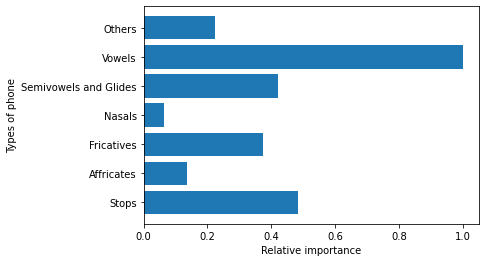

In [155]:
plt.barh(categories, values)
plt.xlabel("Relative importance")
plt.ylabel("Types of phone")
plt.title("")
plt.savefig('phoneGraph.png')
plt.show()

In [156]:
model.uncertainty_loss.log_var_height

Parameter containing:
tensor(-0.0056, device='cuda:0', requires_grad=True)

In [157]:
model.uncertainty_loss.log_var_age

Parameter containing:
tensor(-0.0035, device='cuda:0', requires_grad=True)

In [158]:
model.uncertainty_loss.log_var_gender

Parameter containing:
tensor(-0.0065, device='cuda:0', requires_grad=True)